In [1]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer
from pandas import DataFrame
from collections import OrderedDict 
import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('./fake reviews dataset.csv')

In [3]:
df = df.dropna()
df.count()

category    40432
rating      40432
label       40432
text_       40432
dtype: int64

In [4]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

def preprocess(sentence):
    sentence=str(sentence)
    
    # lower case
    sentence = sentence.lower()
    
    # remove special characters
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    
    # tokenization
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    
    # remove stopwords
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    #filtered_words = [w for w in tokens if len(w) > 2]
    
    # stemming and lemmatization
    #stem_words=[stemmer.stem(w) for w in filtered_words]
    stem_words = filtered_words
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    
    return " ".join(lemma_words)


# clean text
df['cleanText']=df['text_'].map(lambda s:preprocess(s)) 

In [5]:
def create_y(row):
    if row['label'] == 'CG':
        return 1
    else:
        return 0

In [6]:
df['new_label'] = df.apply(lambda row: create_y(row), axis=1)

In [7]:
df['cleanText'] = df['cleanText'].astype('str')

In [8]:
categories = ['Home_and_Kitchen_5', 'Electronics_5', 'Sports_and_Outdoors_5', 
              'Clothing_Shoes_and_Jewelry_5', 'Movies_and_TV_5']

In [9]:
transformers = []
models = []

# depth = 1, n_est = 60
for category in categories:
    
    # take each category data
    y = df[df['category']  == category]['new_label']
    x = df[df['category']  == category]['cleanText']
    x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.20)
    
    # perform tfidf transformation
    tfidf_vect = TfidfVectorizer()
    tfidf_train = tfidf_vect.fit_transform(x_train)
    tfidf_test = tfidf_vect.transform(x_test)
    
    # model training
    Adab = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=70, learning_rate=0.3, random_state=1)
    Adab.fit(tfidf_train, y_train)
    y_pred3 = Adab.predict(tfidf_test)
    
    
    # print the performance of the model
    print(category)
    acc_score = metrics.accuracy_score(y_test,y_pred3)
    auc_score = metrics.roc_auc_score(y_test,y_pred3)
    precision = metrics.precision_score(y_test, y_pred3)
    print(acc_score)
    print(auc_score)
    print(precision)
    print(' ')
    
    
    # make a transformer that fits on all data
    tfidf_transformer = TfidfVectorizer().fit(x)
    tfidf_all = tfidf_transformer.transform(x)
    y_all = y
    
    # make a model that is trained on all data
    Adab_final = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=70, learning_rate=0.3, random_state=1)
    Adab_final.fit(tfidf_all, y_all)
    
    # append to list
    transformers.append(tfidf_transformer)
    models.append(Adab_final)
    

Home_and_Kitchen_5
0.7820197044334976
0.782180710684536
0.7974358974358975
 
Electronics_5
0.8095238095238095
0.8100570954273354
0.8299492385786802
 
Sports_and_Outdoors_5
0.7911392405063291
0.7932754182754183
0.8328981723237598
 
Clothing_Shoes_and_Jewelry_5
0.8389610389610389
0.8389994667962554
0.8457583547557841
 
Movies_and_TV_5
0.7813370473537604
0.7824965719272003
0.8133704735376045
 


In [56]:
import json

final_df_lst = []


categories = ['Home_and_Kitchen_2017', 'Electronics_2017', 'Sports_and_Outdoors_2017', 
              'Clothing_Shoes_and_Jewelry_2017', 'Movies_and_TV_2017']


for category in categories:
    
    idx = categories.index(category)
    
    path = './' + category + '.json'
    #file = open(path, 'r', encoding='utf-8')
    #reviews = []
    
    #for line in file.readlines():
    #    dic = json.loads(line)
    #    if dic['reviewTime'][6:11] == '2018':
    #        reviews.append(dic['reviewText'])
    
    # open json and take corresponding field
    reviews = []
    reviewTimes = []
    reviewRatings = []
    
    with open(path, 'r') as file:
        contents = json.loads(file.read())
    file.close()

    cnt = 0
    for element in contents:
        try:
            reviews.append(element['reviewText'])
            reviewTimes.append(element['reviewTime'])
            reviewRatings.append(element['overall'])
        except:
            cnt += 1
    
    #print(len(reviews))
    # convert to dataframe
    df_a = pd.DataFrame([reviews, reviewTimes, reviewRatings]).T
    df_a.columns = ['review_text', 'review_time', 'review_rating']
    df_a['category'] = category
    df_a['month'] = df_a['review_time'].str[:2].astype('int')
    
    # get count of each month
    df_b = pd.DataFrame(df_a.groupby(['month'])['category'].count()).reset_index()
    df_b.columns = ['month_', 'count']
    df_a = pd.merge(df_a, df_b, how='left', left_on=['month'], right_on=['month_'])
    df_a = df_a.drop(columns = ['month_'])
    
    
    # randomly sample 3000 rows and clean text
    #df_a = df_a.groupby("review_rating").sample(n=100, random_state=123, replace=True)
    #df_a = df_a.sample(n = 3000, replace=False)
    
    # for each month take 1000 samples
    df_a = df_a.groupby("month").sample(n=300, replace=False)
    
    df_a['cleanText']=df_a['review_text'].map(lambda s:preprocess(s)) 

    
    # transform the data and get prediction
    transformer_a = transformers[idx]
    x_a = df_a['cleanText']
    tfidf_a = transformer_a.transform(x_a)
    
    model_a = models[idx]
    pred_a = model_a.predict(tfidf_a)
    df_a['label'] = pred_a
    
    # see the distribution of fake review in each category
    dict_ = df_a['label'].value_counts().to_dict()
    percent = dict_[1] / (dict_[0] + dict_[1])
    print(category)
    print('{:.1%}'.format(percent))
    print(' ')
    
    final_df_lst.append(df_a)

Home_and_Kitchen_2017
12.8%
 
Electronics_2017
20.0%
 
Sports_and_Outdoors_2017
16.9%
 
Clothing_Shoes_and_Jewelry_2017
16.0%
 
Movies_and_TV_2017
27.6%
 


In [57]:
df_final = pd.concat(final_df_lst)

In [58]:
df_final

,review_text,review_time,review_rating,category,month,count,cleanText,label
54519,"The wife says give it a five, well made good v...","01 2, 2017",5.0,Home_and_Kitchen_2017,1,208612,wife say give five well made good value,0
34686,Love these,"01 7, 2017",5.0,Home_and_Kitchen_2017,1,208612,love,0
358495,It is exactly as expected. Sturdy. Looks nice....,"01 5, 2017",5.0,Home_and_Kitchen_2017,1,208612,exactly expected sturdy look nice functional w...,0
623176,Them are beautiful,"01 4, 2017",5.0,Home_and_Kitchen_2017,1,208612,beautiful,0
642094,"Love this vacuum. Easy to maneuver, good suct...","01 7, 2017",5.0,Home_and_Kitchen_2017,1,208612,love vacuum easy maneuver good suction store n...,1
...,...,...,...,...,...,...,...,...
215905,Great movie,"12 7, 2017",5.0,Movies_and_TV_2017,12,10355,great movie,1
206721,Now watching it. love westerns.,"12 3, 2017",5.0,Movies_and_TV_2017,12,10355,watching love western,0
220827,10/10 would watch again. Quality B list horror...,"12 6, 2017",5.0,Movies_and_TV_2017,12,10355,would watch quality list horror movie twist gr...,1
191494,"a little corny, but then so was the original","12 7, 2017",3.0,Movies_and_TV_2017,12,10355,little corny original,0


## Dataset for second plot

In [61]:
df2 = pd.DataFrame(df_final.groupby(['category', 'month']).apply(lambda x: x['label'].sum()/len(x)))

In [62]:
df2 = df2.reset_index()
df2.columns = ['category', 'month', 'fake_prob']

In [63]:
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 
             6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct',
            11: 'Nov', 12: 'Dec'}

In [64]:
df2['month_name'] = df2['month'].map(month_map)

In [65]:
df2['date'] = df2['month_name'] + ' 1,2017'

In [66]:
df2.head()

,category,month,fake_prob,month_name,date
0,Clothing_Shoes_and_Jewelry_2017,1,0.170000,Jan,"Jan 1,2017"
1,Clothing_Shoes_and_Jewelry_2017,2,0.196667,Feb,"Feb 1,2017"
2,Clothing_Shoes_and_Jewelry_2017,3,0.213333,Mar,"Mar 1,2017"
3,Clothing_Shoes_and_Jewelry_2017,4,0.156667,Apr,"Apr 1,2017"
4,Clothing_Shoes_and_Jewelry_2017,5,0.130000,May,"May 1,2017"


### Get weighted average prob

In [67]:
df3 = pd.DataFrame(df_final.groupby(['category', 'month'])['count'].mean()).reset_index()
df3.columns = ['category_', 'month_', 'count']

In [68]:
df3.head()

,category_,month_,count
0,Clothing_Shoes_and_Jewelry_2017,1,277877
1,Clothing_Shoes_and_Jewelry_2017,2,199717
2,Clothing_Shoes_and_Jewelry_2017,3,195475
3,Clothing_Shoes_and_Jewelry_2017,4,176559
4,Clothing_Shoes_and_Jewelry_2017,5,141211


In [69]:
df4 = pd.merge(df2, df3, how='left', left_on=['month', 'category'], right_on=['month_', 'category_'])

In [70]:
df4.head()

,category,month,fake_prob,month_name,date,category_,month_,count
0,Clothing_Shoes_and_Jewelry_2017,1,0.170000,Jan,"Jan 1,2017",Clothing_Shoes_and_Jewelry_2017,1,277877
1,Clothing_Shoes_and_Jewelry_2017,2,0.196667,Feb,"Feb 1,2017",Clothing_Shoes_and_Jewelry_2017,2,199717
2,Clothing_Shoes_and_Jewelry_2017,3,0.213333,Mar,"Mar 1,2017",Clothing_Shoes_and_Jewelry_2017,3,195475
3,Clothing_Shoes_and_Jewelry_2017,4,0.156667,Apr,"Apr 1,2017",Clothing_Shoes_and_Jewelry_2017,4,176559
4,Clothing_Shoes_and_Jewelry_2017,5,0.130000,May,"May 1,2017",Clothing_Shoes_and_Jewelry_2017,5,141211


In [71]:
total_cnt = {}
for row in pd.DataFrame(df4.groupby(['month'])['count'].sum()).reset_index().iterrows():
    total_cnt[row[1]['month']] = row[1]['count']

In [72]:
total_cnt

{1: 790682,
 2: 576407,
 3: 526170,
 4: 458329,
 5: 383953,
 6: 405983,
 7: 263597,
 8: 449044,
 9: 405822,
 10: 330445,
 11: 372027,
 12: 336333}

In [73]:
total_prob = {}

for row in df4.iterrows():
    month = row[1]['month']
    frac = row[1]['count'] / total_cnt[month]
    prob = frac * row[1]['fake_prob']
    if month not in total_prob:
        total_prob[month] = prob
    else:
        total_prob[month] += prob

### Concatenate overall category dataframe with df2

In [74]:
dd = pd.DataFrame([list(total_prob.keys()), list(total_prob.values())]).T
dd.columns = ['month', 'fake_prob']
dd['month'] = dd['month'].astype(int)
dd['category'] = 'Overall_2017'
dd['month_name'] = dd['month'].map(month_map)
dd['date'] = dd['month_name'] + ' 1,2017'

In [75]:
dd = dd[['category', 'month', 'fake_prob', 'month_name', 'date']]

In [76]:
dd

,category,month,fake_prob,month_name,date
0,Overall_2017,1,0.173608,Jan,"Jan 1,2017"
1,Overall_2017,2,0.193785,Feb,"Feb 1,2017"
2,Overall_2017,3,0.184917,Mar,"Mar 1,2017"
3,Overall_2017,4,0.163337,Apr,"Apr 1,2017"
4,Overall_2017,5,0.155253,May,"May 1,2017"
5,Overall_2017,6,0.151320,Jun,"Jun 1,2017"
6,Overall_2017,7,0.158372,Jul,"Jul 1,2017"
7,Overall_2017,8,0.158939,Aug,"Aug 1,2017"
8,Overall_2017,9,0.156125,Sep,"Sep 1,2017"
9,Overall_2017,10,0.154078,Oct,"Oct 1,2017"


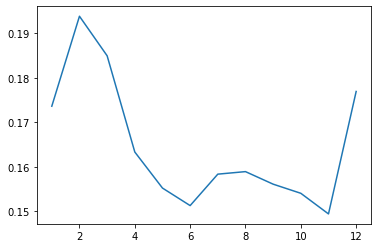

In [77]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(list(dd['month'].values), list(dd['fake_prob'].values))  # Plot the chart
plt.show()  # display

In [78]:
dd.to_csv('./plot_data/time_vs_prob.csv', index=False)